# Data Breach Analytics 2005 - 2017 (Part III Unsupervised Machine Learning)
#### by Miriam Rodriguez 

In [1]:
import warnings
warnings.filterwarnings(action= 'ignore')  # To ignore all warnings that arise here to enhance clarity

In [2]:
# import packages

#import nltk (natural language tool kit), a popular python package for text mining
import nltk
# stopwords, FreqDist, word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#regular expression
import re
#csv
import csv
# Excel-like format
import pandas as pd
#data visualization
import matplotlib.pyplot as plt
% matplotlib inline

import gensim
from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim import corpora, models, similarities

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet

import numpy
import pyLDAvis.gensim

import numpy as np

#vectorizing texts (to numbers)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#to measure distance or similarity between documents or texts
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity

#clustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.cluster import AgglomerativeClustering

In [259]:
#import breach data ... open or read the breach data
df = pd.read_csv("databreach_cleaned.csv")
df.head(2)

Breach_Year                        Company          State Breach_Type  \
0         2006      Deloitte & Touche, McAfee  United States        PORT   
1         2007  TennCare, Americhoice Inc.     United States        PORT   

  Organization_Type  Total_Recs  \
0               BSO        9290   
1               MED       67000   

                                         Description  Breach_Type_CAT  \
0  An external auditor lost a CD with names, Soci...                5   
1  There are 67,000 TennCare \r\n            enro...                5   

   Organization_Type_CAT  State_CAT  Year_CAT       GDP  
0                      2          0         2  72466970  
1                      6          0         3  75725457

In [4]:
df_incident = df[["Description"]]
df_incident

Description
0     An external auditor lost a CD with names, Soci...
1     There are 67,000 TennCare \r\n            enro...
2        A laptop computer was stolen from a vehicle.  
3     A Fidelity laptop used by a former Fidelity em...
4     A former contract worker of a Japanese commerc...
5     Patient names, addresses, Social Security numb...
6     At least 18 colleges are scrambling to inform ...
7     Hundreds of files - with Social Security numbe...
8     A computer was compromised by a virus. That ca...
9     \N\r\nLocation of breached information: Other\...
10    On November 5, 2010, the Puerto Rico Departmen...
11    Triple-S Management Corporation (“TRIPLE-S”), ...
12    The covered entity (CE), Hospital Auxilio Mutu...
13    After a falling out among members of Perverted...
14    Three companies who resell consumer credit rep...
15    The February 1 theft of a contractor's laptop ...
16    A portable electronic device was discovered st...
17    A woman who worked at Regions is accused of cr...
18    A state-owned laptop was stolen from the home ...
19    A courier was attacked on May 9.  The attacker...
20    Subscribers to the ISP news and review site DS...
21    Factions of Anonymous and Antisec posted sensi...
22    An anonymous tipster alerted reporters to a br...
23    A former employee hacked into APA's database, ...
24    A computer or laptop was discovered to have be...
25    State employees who canceled their health or d...
26    The July 25 theft of a laptop resulted in the ...
27    The car theft of backup tapes resulted in the ...
28    \N\r\nLocation of breached information: Deskto...
29    HIPAA settlement demonstrates importance of im...
...                                                 ...
8147  "Wauwatosa, Wis.-based Metropolitan Urology Gr...
8148  Location of breached information: Email\r\nBus...
8149  Location of breached information: Email\r\nBus...
8150  Location of breached information: Email\r\nBus...
8151  Location of breached information: Email\r\nBus...
8152  Location of breached information: Email\r\nBus...
8153  Location of breached information: Paper/Films\...
8154  Location of breached information: Desktop Comp...
8155  "The Medical College of Wisconsin has notified...
8156  "What happened?We have extensive measures in p...
8157  Location of breached information: Email\r\nBus...
8158  Location of breached information: Electronic M...
8159  Location of breached information: Electronic M...
8160  The Doral Corporation experienced a phishing a...
8161  Location of breached information: Laptop\r\nBu...
8162  Location of breached information: Email\r\nBus...
8163  Location of breached information: Network Serv...
8164  A customer of the Rocky Mountain \r\n         ...
8165  The personal information of about 9,000 childr...
8166  Applicants of the Wyoming Kid Care CHIP progra...
8167  On February 23, 2011, The Community Action Par...
8168  The covered entity (CE), Community Action Part...
8169  Location of breached information: Desktop Comp...
8170  The covered entity (CE), Wyoming Department of...
8171  The covered entity (CE), North Big Horn Hospit...
8172  As reported by Health and Human Services hacki...
8173  Location of breached information: Email\r\nBus...
8174  "What HappenedOn February 9, 2017, we learned ...
8175  Location of breached information: Paper/Films\...
8176  Location of breached information: Paper/Films\...

[8177 rows x 1 columns]

In [5]:
# text preprocessing for incident descriptions
# currently the data are in list ... convert to string
tokens = str(df_incident)
#lowercases
tokens = tokens.lower()
# Remove useless numbers and alphanumerical words
tokens = re.sub("[^a-zA-Z0-9]", " ", tokens)

#tokenization or word split
tokens = word_tokenize(tokens)

#get stemming words or lemmas
wordnet_lemmatizer = WordNetLemmatizer()
tokens = (wordnet_lemmatizer.lemmatize(word) for word in tokens)

#Remove stopwords
tokens = (word for word in tokens if word not in stopwords.words('english'))

more_stopwords = set(('location', 'three', 'member', 'covered', 'discovered', 'soci', 'based', 'resulted', 'comp', 'perverted',
                'action', 'doral', 'childre', 'ago', 'hour', 'year', 'abuse', 'also', 'pm', 'now', 'columns', 'else',
                'simply', 'new', 'yesterday', 'getting', 'will', 'people', 'need', 'think', 'well','going', 'can', 'country', 
                'know', 'lot', 'get','make','way','want', 'like','say','got','said','just','something','tell','put','now',
                'bad','back','want','right','every','one','use','come','never', 'many','along','things','day','also','first',
                'guy', 'great', 'take', 'good', 'much','anderson', 'let', 'would', 'year', 'thing', 'america',
                'talk', 'talking', 'thank', 'does', 'give', 'look', 'believe', 'tonight','today','see','http','com','www'))

extra_stoplist = set(stopwords.words('english')) | more_stopwords

tokens = (word for word in tokens if word not in extra_stoplist)

# Filter non-alphanumeric characters from tokens
tokens = (word for word in tokens if word.isalpha())

#remove short words
tokens = (word for word in tokens if len(word) >= 3)



In [6]:
# Word frequency analysis for breach descriptions
#compute frequency distribution for all the bigrams in the text
fdist = nltk.FreqDist(tokens)
fdist

FreqDist({'information': 20, 'breached': 19, 'nbus': 8, 'email': 8, 'laptop': 7, 'entity': 4, 'paper': 3, 'theft': 3, 'february': 3, 'computer': 3, ...})

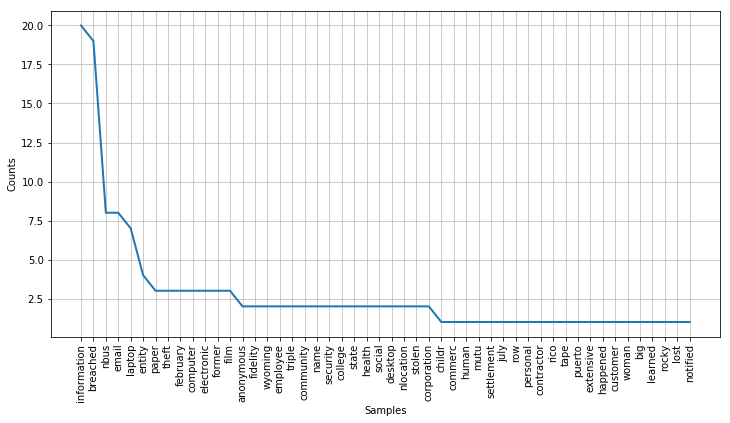

In [7]:
plt.figure(figsize=(12,6))
fdist.plot(50)

## Popular words from the breach dataset

In [8]:
# Most popular words for breaches
fdist.most_common(50)



[('information', 20),
 ('breached', 19),
 ('nbus', 8),
 ('email', 8),
 ('laptop', 7),
 ('entity', 4),
 ('paper', 3),
 ('theft', 3),
 ('february', 3),
 ('computer', 3),
 ('electronic', 3),
 ('former', 3),
 (u'film', 3),
 ('anonymous', 2),
 ('fidelity', 2),
 ('wyoming', 2),
 ('employee', 2),
 ('triple', 2),
 ('community', 2),
 (u'name', 2),
 ('security', 2),
 (u'college', 2),
 ('state', 2),
 ('health', 2),
 ('social', 2),
 ('desktop', 2),
 ('nlocation', 2),
 ('stolen', 2),
 ('corporation', 2),
 ('childr', 1),
 ('commerc', 1),
 ('human', 1),
 ('mutu', 1),
 ('settlement', 1),
 ('july', 1),
 (u'row', 1),
 ('personal', 1),
 ('contractor', 1),
 ('rico', 1),
 (u'tape', 1),
 ('puerto', 1),
 ('extensive', 1),
 ('happened', 1),
 ('customer', 1),
 ('woman', 1),
 ('big', 1),
 ('learned', 1),
 ('rocky', 1),
 ('lost', 1),
 ('notified', 1)]

The most popular words for breach descriptions relate to theft of electronic data or stolen data, employees such as former and contractors in corporations.

In [9]:
# Word frequency analysis using bi-grams
# what if you have additional stopwords to be removed
tokens = str(df_incident)
#lowecases
tokens = tokens.lower()
# Remove useless numbers and alphanumerical words
tokens = re.sub("[^a-zA-Z0-9]", " ", tokens)
#tokenization or word split
tokens = word_tokenize(tokens)
#get stemming words or lemmas
wordnet_lemmatizer = WordNetLemmatizer()
tokens = (wordnet_lemmatizer.lemmatize(word) for word in tokens)

tokens = (word for word in tokens if word not in stopwords.words('english'))

#additional stopwords
more_stopwords = set(('location', 'three', 'member', 'covered', 'discovered', 'soci', 'based', 'resulted', 'comp', 'perverted',
                'action', 'doral', 'childre', 'ago', 'hour', 'year', 'abuse', 'also', 'pm', 'now', 'columns', 'else',
                'simply', 'new', 'yesterday', 'getting', 'will', 'people', 'need', 'think', 'well','going', 'can', 'country', 
                'know', 'lot', 'get','make','way','want', 'like','say','got','said','just','something','tell','put','now',
                'bad','back','want','right','every','one','use','come','never', 'many','along','things','day','also','first',
                'guy', 'great', 'take', 'good', 'much','anderson', 'let', 'would', 'year', 'thing', 'america',
                'talk', 'talking', 'thank', 'does', 'give', 'look', 'believe', 'tonight','today','see','http','com','www'))

extra_stoplist = set(stopwords.words('english')) | more_stopwords

# Filter non-alphanumeric characters from tokens
tokens = (word for word in tokens if word.isalpha())
#remove short words
tokens = (word for word in tokens if len(word) >= 3)
#Create your bigrams ... a bigram are a pair of two tokens
bigrams = nltk.bigrams(tokens)
#compute frequency distribution for all the bigrams in the text
fdist_bi = nltk.FreqDist(bigrams)
fdist_bi



FreqDist({('breached', 'information'): 19, ('location', 'breached'): 17, ('information', 'email'): 8, ('email', 'nbus'): 8, ('nbus', 'location'): 7, ('covered', 'entity'): 4, ('information', 'paper'): 3, ('paper', u'film'): 3, ('social', 'security'): 2, (u'film', 'location'): 2, ...})

## Popular bi-grams 

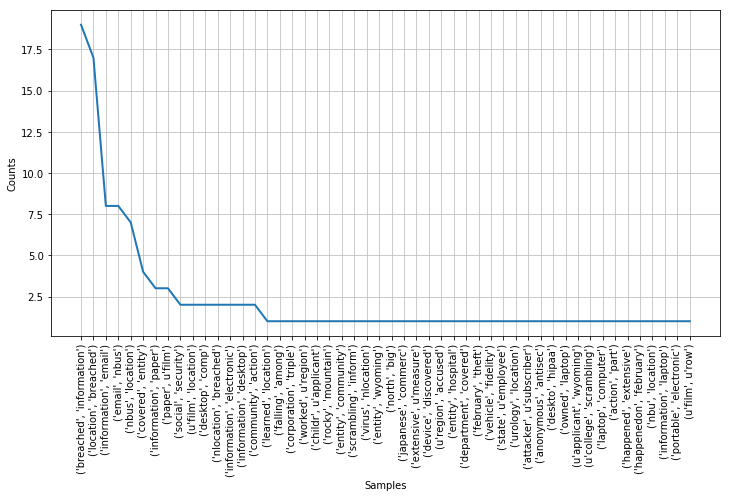

In [10]:
# plot word frequency using bigram
plt.figure(figsize=(12,6))
fdist_bi.plot(50)

In [11]:
# Most popular words 
fdist_bi.most_common(50)

[(('breached', 'information'), 19),
 (('location', 'breached'), 17),
 (('information', 'email'), 8),
 (('email', 'nbus'), 8),
 (('nbus', 'location'), 7),
 (('covered', 'entity'), 4),
 (('information', 'paper'), 3),
 (('paper', u'film'), 3),
 (('social', 'security'), 2),
 ((u'film', 'location'), 2),
 (('desktop', 'comp'), 2),
 (('nlocation', 'breached'), 2),
 (('information', 'electronic'), 2),
 (('information', 'desktop'), 2),
 (('community', 'action'), 2),
 (('learned', 'location'), 1),
 (('falling', 'among'), 1),
 (('corporation', 'triple'), 1),
 (('worked', u'region'), 1),
 (('childr', u'applicant'), 1),
 (('rocky', 'mountain'), 1),
 (('entity', 'community'), 1),
 (('scrambling', 'inform'), 1),
 (('virus', 'nlocation'), 1),
 (('entity', 'wyoming'), 1),
 (('north', 'big'), 1),
 (('japanese', 'commerc'), 1),
 (('extensive', u'measure'), 1),
 (('device', 'discovered'), 1),
 ((u'region', 'accused'), 1),
 (('entity', 'hospital'), 1),
 (('department', 'covered'), 1),
 (('february', 'theft

In [12]:
df_incident.to_csv('databreach.txt', index=False, sep=' ', header=None)

In [13]:
df_incident.to_csv('databreach.csv', index=False, header=None)

## Word cloud using a mask image. 

(-0.5, 399.5, 199.5, -0.5)

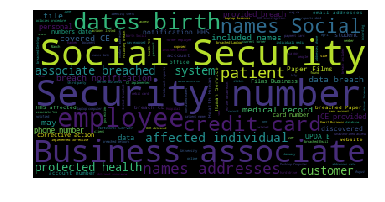

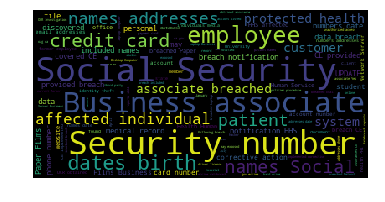

In [14]:
# word cloud 
from os import path
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

# Read the whole text.
text = open(path.join('databreach.txt')).read()

#additional stopwords
stopwords = set(STOPWORDS)
stopwords.add("report")
stopwords.add("company")
stopwords.add("ago")
stopwords.add("said")
stopwords.add("hours")
stopwords.add("will")
stopwords.add("well")
stopwords.add("year")
stopwords.add("abuse")
stopwords.add("also")
stopwords.add("pm")
stopwords.add("now")
stopwords.add("information")
stopwords.add("happened")
stopwords.add("home")
stopwords.add("hour")
stopwords.add("entity")
stopwords.add("big")
stopwords.add("used")
stopwords.add("name")
stopwords.add("par")
stopwords.add("else")
stopwords.add("simply")
stopwords.add("new")
stopwords.add("yesterday")
stopwords.add("getting")
stopwords.add("vehicle")
stopwords.add("location")
stopwords.add("present")
stopwords.add("film")
stopwords.add("row")

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords).generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud)
plt.axis("off")

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=40, relative_scaling=.5, stopwords=stopwords).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")


## The themes here appear to be social security number, credit cards, birthdates, names and addresses, employees and business associates.

In [15]:
#import breach data ... open or read the breach data
from nltk.corpus import stopwords
texts = []
r = csv.reader(open('databreach.csv', 'rb'))
for i in r:
    texts.append(i)  
len(texts)

8177

In [16]:
# Remove useless numbers and alphanumerical words
documents = [re.sub("[^a-zA-Z]+", " ", str(text)) for text in texts]

# tokenize
texts = [[word for word in text.lower().split() ] for text in documents]

# stemming words: having --> have; friends --> friend
lmtzr = WordNetLemmatizer()
texts = [[lmtzr.lemmatize(word) for word in text ] for text in texts]

porter_stemmer = PorterStemmer()
texts = [[porter_stemmer.stem(word) for word in text ] for text in texts]

# remove common words 
stoplist = stopwords.words('english')
texts = [[word for word in text if word not in stoplist] for text in texts]

#remove short words
texts = [[ word for word in tokens if len(word) >= 3 ] for tokens in texts]


In [17]:
# A list of extra stopwords 
extra_stopwords = ['location', 'three', 'member', 'covered', 'discovered', 'soci', 'based', 'resulted', 'comp', 'perverted',
                'action', 'doral', 'childre', 'ago', 'hour', 'year', 'abuse', 'also', 'pm', 'now', 'columns', 'else',
                'simply', 'new', 'yesterday', 'getting', 'will', 'people', 'need', 'think', 'well','going', 'can', 'country', 
                'know', 'lot', 'get','make','way','want', 'like','say','got','said','just','something','tell','put','now',
                'bad','back','want','right','every','one','use','come','never', 'many','along','things','day','also','first',
                'guy', 'great', 'take', 'good', 'much','anderson', 'let', 'would', 'year', 'thing', 'america',
                'talk', 'talking', 'thank', 'does', 'give', 'look', 'believe', 'tonight','today','see', 'mon','day', 'tues', 'wed', 'wednes', 
                'thurs', 'thu', 'fri', 'sat', 'sun', 'easter', 'lord', 'eat', 'deli', 'delt', 'voyeur', 'wjb', 'delv', 'oceana', 'broward', 
                'disturb', 'carthag', 'wednesday', 'assail', 'inur', 'charter', 'kuroi', 'miller', 'seper', 'frederick', 'budget', 'second', 
                'nget', 'nsuggest', 'melvin', 'maloney', 'decre', 'clorox', 'ongo', 'widget', 'cenabl', 'suntim', 'chine', 'fun', 'dorm', 'chino', 
                'dorn', 'tatum', 'ultraex', 'strewn', 'kidz', 'reportd', 'aroudn', 'controversi', 'golden', 'nwhen', 'tautoneum', 'loudoun', 
                'swanson', 'tfeinstein', 'brought', 'remnant', 'sterl', 'stern', 'unit', 'dna', 'spoke', 'dnc', 'overshadow', 'dnr', 'lmg', 
                'untim', 'relay', 'glass', 'holi', 'midst', 'hold', 'unpack', 'adventist', 'blade', 'fahlgren', 'bizmat', 'ccoordin', 'unjust', 
                'household', 'cautiou', 'caution', 'troldesh', 'sprechman', 'hog', 'tacoma', 'hoc', 'turn', 'hot', 'machinc', 'perspect', 
                'diagram', 'wrong', 'beauti', 'allina', 'elanc', 'vicin', 'blackheart', 'warfar', 'marquett', 'winn', 'menlo', 'fifti', 'wing', 
                'wind', 'wine', 'feedback', 'murali', 'affect', 'jordi', 'vari', 'fir', 'fit', 'fiu', 'fix', 'zevin', 'easier', 'hillsid', 'nrelat', 
                'auditori', 'township','http','com','www']
extra_stoplist = extra_stopwords
texts = [[word for word in text if word not in extra_stoplist] for text in texts]


In [18]:
# this is text processing required for topic modeling with Gensim

## Create a dictionary representation of the documents.
dictionary = Dictionary(texts)
dictionary.save('databreach.dict')  # store the dictionary, for future reference

len(dictionary)

10589

In [19]:
## Remove rare and common tokens.
# ignore words that appear in less than 2 documents or more than 40% documents (remove too frequent & infrequent words) - an optional step
dictionary.filter_extremes(no_below=2, no_above=0.4) 
len(dictionary)

5023

In [20]:
# convert words to vectors or integers, this is text processing required for topic modeling with Gensim
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('databreach.mm', corpus)  # store to disk, for later use  # store to disk, for later use
len(corpus)

8177

In [21]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 5023
Number of documents: 8177


In [22]:
# Save the dict and corpus for later retrievalsaved dict

saved_dict = dictionary.load('databreach.dict')



In [23]:
# save the corpus
corpus_saved = corpora.MmCorpus('databreach.mm')

## Optimal k value - Also used in Classification Models


In [24]:
numpy.random.seed(1) # setting random seed to get the same results each time. We normally do not include this line.
for k in range(2,10):
    goodLdaModel = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=k, passes=75)
    goodcm = CoherenceModel(model=goodLdaModel, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    print goodcm.get_coherence()

-1.36921718723
-1.4170374577
-1.5576261135
-1.57333318701
-1.74954554895
-1.91478770384
-1.77490330283
-1.99945749239


Based on the above, the best number of topics is 3. For this model we will use 10.

In [25]:
numpy.random.seed(1) # setting random seed to get the same results each time. 
model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10, passes=75)

In [26]:
model.save('lda.model') # same for tfidf, lda, ...
#model = models.LdaModel.load('data/lda.model')

## Prints the topics (Term-Topic Distribution)

In [27]:
# print words without probability
for i in range(0,10):
    topics = model.show_topic(i, 10)
    print ', '.join([str(word[0]) for word in topics])

employe, hacker, access, ident, onlin, post, tax, password, theft, databas
patient, social, contain, employe, date, laptop, stolen, birth, medic, record
data, compani, employe, updat, state, includ, custom, million, notifi, servic
health, report, servic, human, electron, laptop, specif, gov, ocr, desktop
mail, sent, email, employe, address, document, form, social, paper, receiv
card, credit, custom, payment, system, may, debit, bank, store, data
individu, health, ocr, associ, provid, phi, protect, entiti, cover, notif
access, account, address, email, may, includ, investig, unauthor, thi, data
student, social, univers, drive, comput, person, school, contain, former, hard
associ, present, nbusi, locat, nlocat, paper, server, film, network, email


## Assign the topics to the documents in corpus (Document-Topic Distribution)


In [28]:
lda_corpus = model[corpus]

results = []
for i in lda_corpus:
#    print i
    results.append(i)
print 

In [29]:
# finding highest value from each row
toptopic = [max(collection, key=lambda x: x[1])[0] for collection in results]
# toptopic

In [30]:
toptopic = pd.DataFrame(toptopic)
documents = pd.DataFrame(documents)
documents = documents.rename(columns = {0: 'documents'})
summary = documents.join(toptopic)
summary.head(10)

documents  0
0   An external auditor lost a CD with names Soci...  1
1   There are TennCare r r n enrollees at risk of...  1
2   A laptop computer was stolen from a vehicle x...  1
3   A Fidelity laptop used by a former Fidelity e...  1
4   A former contract worker of a Japanese commer...  2
5   Patient names addresses Social Security numbe...  1
6   At least colleges are scrambling to inform te...  1
7   Hundreds of files with Social Security number...  1
8   A computer was compromised by a virus That ca...  8
9   N r r nLocation of breached information Other...  9

### Top 10 topics show persistent cases of physical loss and theft and hacking. 

## pyLDAvis

In [31]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(model, corpus, dictionary)

C:\Users\DOUGR\Anaconda2\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
6      20.475693        1       1 -0.106675 -0.076893
1      19.703651        1       2  0.100572 -0.060720
7      16.819216        1       3  0.097880 -0.022014
5       9.311756        1       4  0.136355 -0.064578
0       8.808444        1       5  0.151916  0.064402
8       6.381554        1       6  0.104231  0.096299
2       6.198937        1       7  0.136116  0.044026
4       5.541771        1       8 -0.015268  0.100461
9       3.691940        1       9 -0.372868  0.243401
3       3.067031        1      10 -0.232259 -0.324384, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
2719  Default  3082.000000       associ  3082.000000  30.0000  30.0000
4613  Default  2449.000000      present  2449.000000  29.0000  29.0000
3827  Default  2403.000000        nbusi  2403.000000  28.0000  28.0000
1646  Default  2369.000000         card  2369.000000  27.0000  27.0000
2841  Default  2725.000000       health  2725.000000  26.0000  26.0000
635   Default  2075.000000       report  2075.000000  25.0000  25.0000
1965  Default  1555.000000       nlocat  1555.000000  24.0000  24.0000
4360  Default  1126.000000        locat  1126.000000  23.0000  23.0000
881   Default  2235.000000       laptop  2235.000000  22.0000  22.0000
788   Default  1750.000000       servic  1750.000000  21.0000  21.0000
913   Default  1829.000000       credit  1829.000000  20.0000  20.0000
3579  Default  1881.000000       custom  1881.000000  19.0000  19.0000
621   Default  1541.000000          ocr  1541.000000  18.0000  18.0000
3513  Default  2714.000000      patient  2714.000000  17.0000  17.0000
4650  Default  1020.000000      student  1020.000000  16.0000  16.0000
843   Default  3471.000000       social  3471.000000  15.0000  15.0000
2065  Default  1791.000000        medic  1791.000000  14.0000  14.0000
4465  Default  2088.000000        email  2088.000000  13.0000  13.0000
504   Default  1929.000000       provid  1929.000000  12.0000  12.0000
3753  Default   936.000000     electron   936.000000  11.0000  11.0000
3075  Default  2629.000000       access  2629.000000  10.0000  10.0000
3941  Default  3739.000000      employe  3739.000000   9.0000   9.0000
4924  Default  1751.000000       record  1751.000000   8.0000   8.0000
657   Default   597.000000        human   597.000000   7.0000   7.0000
3484  Default  1189.000000       server  1189.000000   6.0000   6.0000
2979  Default  2427.000000       comput  2427.000000   5.0000   5.0000
1538  Default   813.000000         mail   813.000000   4.0000   4.0000
2074  Default  2678.000000      contain  2678.000000   3.0000   3.0000
3552  Default   676.000000      univers   676.000000   2.0000   2.0000
225   Default   779.000000        drive   779.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
2997  Topic10    11.417656  hospitalist    12.332757   3.4074  -6.6645
1154  Topic10    11.417344   parenthood    12.332801   3.4073  -6.6645
2178  Topic10    11.204927   blackberri    12.120051   3.4060  -6.6833
4747  Topic10    11.031247       npaper    11.946266   3.4048  -6.6989
4674  Topic10    10.514044      vincent    11.429145   3.4010  -6.7470
1613  Topic10     8.224759      jackson     9.140026   3.3789  -6.9925
931   Topic10   282.188354       specif   353.866974   3.2581  -3.4571
2144  Topic10   256.657196      desktop   409.614441   3.0170  -3.5519
4471  Topic10    20.265488     patholog    23.711987   3.3274  -6.0908
788   Topic10   647.786133       servic  1750.776489   2.4902  -2.6261
2495  Topic10   281.142181          gov   646.048889   2.6524  -3.4608
3753  Topic10   366.685913     electron   936.509338   2.5468  -3.1952
4883  Topic10   125.152885    disclosur   245.896896   2.8091  -4.2701
635   Topic10   650.448059       report  20

#### get_term_topics - The function get_term_topics returns the odds of that particular word belonging to a particular topic. 

In [32]:
model.get_term_topics('hack')

[(3, 0.012008906)]

In [33]:
model.get_term_topics('theft')

[(0, 0.011552008)]

In [34]:
summary.groupby(0).count()

documents
0           
0        575
1       2292
2        194
3        229
4        197
5        551
6        938
7       1075
8        594
9       1532

## Biggest group of words belong to topic 2 (2), next being topic 10, then topic 8.

## Topics

In [35]:
model.show_topics(num_topics=10, num_words=10, log=False, formatted=True)

[(0,
  u'0.026*"employe" + 0.026*"hacker" + 0.022*"access" + 0.017*"ident" + 0.015*"onlin" + 0.015*"post" + 0.014*"tax" + 0.014*"password" + 0.012*"theft" + 0.011*"databas"'),
 (1,
  u'0.036*"patient" + 0.032*"social" + 0.026*"contain" + 0.025*"employe" + 0.024*"date" + 0.023*"laptop" + 0.023*"stolen" + 0.020*"birth" + 0.019*"medic" + 0.018*"record"'),
 (2,
  u'0.034*"data" + 0.032*"compani" + 0.021*"employe" + 0.021*"updat" + 0.017*"state" + 0.016*"includ" + 0.016*"custom" + 0.015*"million" + 0.015*"notifi" + 0.011*"servic"'),
 (3,
  u'0.078*"health" + 0.073*"report" + 0.072*"servic" + 0.067*"human" + 0.041*"electron" + 0.035*"laptop" + 0.032*"specif" + 0.031*"gov" + 0.030*"ocr" + 0.029*"desktop"'),
 (4,
  u'0.042*"mail" + 0.035*"sent" + 0.025*"email" + 0.023*"employe" + 0.021*"address" + 0.019*"document" + 0.019*"form" + 0.018*"social" + 0.016*"paper" + 0.016*"receiv"'),
 (5,
  u'0.087*"card" + 0.058*"credit" + 0.052*"custom" + 0.022*"payment" + 0.017*"system" + 0.013*"may" + 0.012*"

- Top topics: 
- 1) Hacking getting email, passwords, etc. 
- 2) Stolen laptop from employee containing patient medical information, birthdate, etc.
- 3) Looks like an insider breach


## LSI (Latent Semantic Indexing) and Results


In [36]:
tfidf = models.TfidfModel(corpus)

In [37]:
corpus_tfidf = tfidf[corpus]

In [38]:
for doc in corpus_tfidf:
    print(doc)

[(0, 0.22398448832802068), (1, 0.073603867469639983), (2, 0.33246930587310175), (3, 0.22009873050148768), (4, 0.25738507426218937), (5, 0.1621732875060187), (6, 0.28326036171854535), (7, 0.13563775373064019), (8, 0.13682127748638429), (9, 0.66429346613371743), (10, 0.12690048446109209), (11, 0.11529321593054688), (12, 0.076282480191930901), (13, 0.03685237997510693), (14, 0.2516694828503695), (15, 0.15331740408739822), (16, 0.10406654298575115)]
[(8, 0.4234211923190167), (12, 0.11803580301731009), (13, 0.057023581987845663), (17, 0.069964610900259849), (18, 0.38168569943017039), (19, 0.38543246893940231), (20, 0.4032120176626699), (21, 0.17613697909134216), (22, 0.072795034409568207), (23, 0.096710948730237806), (24, 0.19335290693224602), (25, 0.48888884808961092), (26, 0.14049627227181308)]
[(27, 0.31336177523400194), (28, 0.38320258138222013), (29, 0.34362947069350258), (30, 0.79804696999305813)]
[(3, 0.087553118941827976), (6, 0.075118798079214386), (13, 0.029319031508254594), (23, 

[(17, 0.12907002363628076), (22, 0.067145780494949792), (59, 0.21505317315073627), (62, 0.12740151493263982), (65, 0.22954430033533502), (66, 0.094769171680280609), (83, 0.075782650541688548), (86, 0.31883483686763187), (136, 0.12566904916621685), (162, 0.20210247192930983), (184, 0.09747890487004042), (289, 0.1847445877742083), (312, 0.11922211411970141), (314, 0.12952540460091569), (388, 0.10549445408962663), (441, 0.12217588299726317), (489, 0.16883683715744166), (664, 0.14649150518742485), (690, 0.18112116577475323), (696, 0.17616094568236965), (703, 0.20821617168769488), (746, 0.27739088146883284), (788, 0.18264594946412233), (789, 0.18510199690296178), (792, 0.18095423573072367), (796, 0.13565952264227127), (842, 0.33794352802335365), (1008, 0.21068913351686153), (1665, 0.28017224134379215)]
[(44, 0.05027682830773067), (71, 0.10316871650198599), (108, 0.054053184359307546), (116, 0.10520519982283386), (121, 0.10138071344497196), (174, 0.069065617515966293), (214, 0.10002533853503

[(12, 0.03070576999309018), (13, 0.01483408379442405), (17, 0.036401112120944788), (22, 0.037873721804417046), (23, 0.02515833392592522), (40, 0.03196169600984599), (45, 0.054192303587630337), (62, 0.071861098321479772), (64, 0.068142129012485508), (66, 0.053454754973381306), (71, 0.11386037288419426), (85, 0.057134996077659567), (86, 0.044959868751505573), (90, 0.10629026772199524), (98, 0.11855431102209801), (99, 0.030652753163614897), (101, 0.041059627418683749), (108, 0.029827431877619513), (112, 0.043630917428586866), (118, 0.047630294407961925), (122, 0.05734244849106461), (125, 0.048001034119794228), (126, 0.052052627557725113), (136, 0.07088389728234501), (148, 0.06048385824744492), (155, 0.14969861600429446), (162, 0.056998166835006046), (165, 0.04248613940943214), (174, 0.038111538218533927), (179, 0.042376020218864198), (201, 0.072676714409536963), (217, 0.077003587175960356), (220, 0.065741841768617915), (234, 0.056998166835006046), (248, 0.14065586772207905), (279, 0.05998

[(40, 0.12548173430254214), (98, 0.15514821816206795), (118, 0.093498354183247492), (136, 0.1391452187388908), (186, 0.13831102565846162), (388, 0.11680719307922545), (394, 0.16139904830790008), (489, 0.18694212133635044), (694, 0.33580945342333823), (701, 0.23948525105703425), (796, 0.15020702454034965), (1528, 0.46706316104272899), (2151, 0.52489914892946365), (2403, 0.38981883391239514)]
[(17, 0.042346523479164691), (31, 0.18027793646783413), (40, 0.074364030748175852), (62, 0.0835982064833167), (98, 0.1838904591183193), (101, 0.095531832695331206), (113, 0.16785396647688311), (118, 0.055409773574081), (139, 0.041825120750669048), (144, 0.12942671871186462), (155, 0.11609930920721881), (156, 0.3047502968185859), (346, 0.10521093492237511), (360, 0.13806598168924131), (378, 0.19189164418157784), (381, 0.091838506185381377), (388, 0.069223251862368135), (422, 0.068846721603979061), (445, 0.12018799479541407), (449, 0.14466660243627347), (471, 0.12099246702952507), (479, 0.152686928962

[(3, 0.075964209238549338), (12, 0.052655808357751216), (23, 0.043142784242243014), (124, 0.062938632991114893), (130, 0.065283515420179267), (132, 0.10773167125846869), (167, 0.17617104606689524), (182, 0.049094100521416995), (184, 0.047143974816419028), (274, 0.090944653246859505), (290, 0.28686377546815328), (382, 0.10314638045950301), (386, 0.21422715347612234), (393, 0.087524732296607899), (442, 0.21325119049323205), (646, 0.17027010896974959), (664, 0.070848065441263), (788, 0.088333532812430698), (789, 0.089521357385951975), (792, 0.087515364925232278), (854, 0.13691459368615366), (942, 0.1234176343077608), (950, 0.080883750459821352), (1329, 0.13789934959991579), (1330, 0.13789934959991579), (1339, 0.27480515035519765), (1340, 0.13789934959991579), (1341, 0.13789934959991579), (1461, 0.16869423809568215), (1498, 0.11685357140296543), (1574, 0.16193615444284251), (1601, 0.16316169996152133), (2611, 0.17987300621383606), (2831, 0.16869423809568215), (2900, 0.57315532299596983)]
[

[(66, 0.11043293165473363), (134, 0.14906899832676546), (175, 0.14578051217918864), (182, 0.11828924766080483), (184, 0.11359053844649558), (465, 0.18643542944818547), (524, 0.27772333640762031), (544, 0.25768940754666181), (588, 0.25061186719295819), (664, 0.17070410233128719), (679, 0.20932695167917845), (788, 0.21283427191104506), (789, 0.21569626293771746), (792, 0.21086294617518173), (961, 0.26258208211707396), (1605, 0.30492414598277962), (3187, 0.55241749816445251)]
[(17, 0.11071596761268614), (22, 0.0575974951361031), (44, 0.084383601793905777), (85, 0.17377920636785535), (94, 0.062991908199032762), (98, 0.24039293480659807), (108, 0.090721760663789591), (118, 0.072435068955219409), (124, 0.11163146432945653), (155, 0.15177216807852137), (159, 0.11263852809222141), (163, 0.15235696892372605), (184, 0.083617179035503114), (238, 0.30812103769252647), (280, 0.12990073879419878), (291, 0.15862653199289423), (346, 0.13753821454903392), (379, 0.1660624282150896), (388, 0.180985797216

[(17, 0.092783579095574567), (23, 0.042751079655170596), (32, 0.096855903802558069), (59, 0.051531209025508798), (62, 0.061056100684072759), (83, 0.072636391239549028), (86, 0.30559780881212606), (98, 0.067152364022361619), (108, 0.05068518924439832), (118, 0.080937255870337677), (124, 0.062367196731733472), (130, 0.064690789361825846), (198, 0.1039543045028658), (257, 0.062498542740338441), (285, 0.083842349548087503), (293, 0.15818791522436623), (388, 0.050557326684169214), (393, 0.086730072431116467), (434, 0.086324267659189644), (455, 0.20385936168440066), (584, 0.088708569640679566), (586, 0.15608534595542925), (604, 0.073199885301035911), (693, 0.16668733414164091), (701, 0.10365572320121237), (703, 0.099785842808365888), (774, 0.10614106464634156), (796, 0.13002736235246645), (806, 0.29207827084419113), (837, 0.13427018183742451), (842, 0.08097829167664948), (843, 0.14899552159082755), (912, 0.097918151017576713), (913, 0.2230303471821406), (916, 0.09247964371545711), (921, 0.14

[(11, 0.13827663844341315), (27, 0.073416756687068943), (92, 0.59853451423681414), (102, 0.12921135121390515), (122, 0.17085437553021129), (127, 0.098505729618294999), (285, 0.2940208293712141), (349, 0.18874684783193341), (393, 0.076036895331149559), (441, 0.1026655224418867), (642, 0.18415380927693706), (756, 0.18280433563103379), (1048, 0.26863525194859827), (1055, 0.2139251928688975), (1293, 0.24712912379386034), (2557, 0.2857211040350765), (3300, 0.30869416354838752)]
[(13, 0.011246591974364723), (16, 0.03175897860420436), (20, 0.079524310534875811), (22, 0.014357148765904519), (23, 0.038148027251410574), (24, 0.038134420454116434), (27, 0.018681232860249291), (40, 0.024232042828727686), (49, 0.037798609218609648), (51, 0.042807321341940402), (55, 0.051457693524333742), (62, 0.027241063986546247), (66, 0.020263597894102515), (71, 0.086324249857540475), (76, 0.046720272535739966), (87, 0.06181891228209907), (93, 0.4077347986056854), (94, 0.015701797359844394), (95, 0.02614916355291

[(1, 0.05137474367879389), (3, 0.038406663441312959), (10, 0.088575235052594459), (12, 0.053244387853119572), (44, 0.048107888638578421), (57, 0.080351474440488596), (125, 0.083234704050746386), (126, 0.090260243956793079), (127, 0.057327825085396182), (130, 0.13202649143018821), (134, 0.062560314760273045), (139, 0.031171517424663567), (140, 0.03336216141562489), (141, 0.043156200974342057), (142, 0.032748443376863501), (154, 0.062304254077345252), (161, 0.06259248834822119), (165, 0.073671771970107644), (173, 0.067127045408012453), (174, 0.066086130490889933), (175, 0.061180224125825799), (177, 0.056102489654271934), (182, 0.04964286772890409), (184, 0.09534188756570891), (227, 0.076919473171807487), (274, 0.091961220265464716), (276, 0.11073661671137493), (288, 0.095604850265618602), (337, 0.091777203684062794), (403, 0.087063624287914365), (434, 0.088088971372551533), (441, 0.059748718532979576), (444, 0.094169615148823119), (464, 0.19379349045447991), (490, 0.074448920853181097), 

[(3, 0.31715293400165984), (13, 0.053102716255649551), (40, 0.11441575346218244), (75, 0.24344796111636738), (81, 0.090636262729041767), (83, 0.076509446829329891), (87, 0.19459241019453369), (112, 0.15618896726569825), (118, 0.085252923071318543), (127, 0.11834982719567505), (130, 0.13628035271474545), (132, 0.11244576876075343), (166, 0.29109516826081722), (184, 0.098413779880039118), (212, 0.34904009631531385), (394, 0.14716559205106119), (422, 0.1059268768310223), (503, 0.31280346768068484), (609, 0.18871614417080232), (902, 0.24296634079207102), (1046, 0.27481548348846924), (1516, 0.26213990069909732), (1950, 0.33098807096215044)]
[(3, 0.062301591363410153), (13, 0.083452073085454256), (16, 0.23565828738506792), (23, 0.070766592348755528), (43, 0.13393771230161194), (81, 0.14243685737359477), (83, 0.12023625906047009), (87, 0.15290310159700402), (95, 0.097016141108156539), (112, 0.12272717885699461), (118, 0.13397682206396319), (155, 0.1403598633245505), (371, 0.14394884928418636)

[(3, 0.035864897099838262), (21, 0.37097413998501205), (26, 0.17754528564989297), (77, 0.10145460730625619), (112, 0.070649842880973743), (160, 0.088503403213885501), (172, 0.15910771699792858), (257, 0.059555453581054539), (265, 0.10822218758646264), (321, 0.10722461696036611), (363, 0.11362774787371174), (371, 0.16573286666476841), (405, 0.10357762826021848), (431, 0.12507459256006953), (476, 0.10863217098776669), (491, 0.08613509780101497), (492, 0.11362774787371174), (543, 0.18684414379273917), (570, 0.23478337996704318), (593, 0.11653805914975753), (598, 0.10274046905493048), (623, 0.068617836773291252), (700, 0.10497573105936568), (749, 0.23363900827776307), (762, 0.097666549022477275), (856, 0.089873899003088259), (871, 0.2604250624398417), (1151, 0.14273388870074702), (1163, 0.1188797182881032), (1166, 0.12546607975602148), (1300, 0.19263791704916583), (1570, 0.1698464822727086), (1592, 0.27324042765249473), (2269, 0.34422336989024505), (4080, 0.20593644889782428), (4081, 0.183

[(1, 0.077798434038483896), (59, 0.079630630675948499), (112, 0.1145695950935712), (316, 0.22058015356254665), (382, 0.1579438550541421), (418, 0.18467278207969878), (520, 0.1815148859377822), (708, 0.21963141300248912), (1522, 0.21690677875518066), (1861, 0.29254980755021132), (1907, 0.24279031953919528), (2054, 0.28757734014555436), (2065, 0.29818712614727111), (2531, 0.32181252558729218), (2904, 0.26892440811019025), (4199, 0.35107524362437309), (4200, 0.35107524362437309)]
[(3, 0.099250248018103768), (13, 0.066472129925566142), (22, 0.084856840214637047), (23, 0.11273551266196077), (28, 0.1350226404387547), (29, 0.12107892983980081), (160, 0.24491872080302135), (167, 0.23017444913880661), (220, 0.2945918540134046), (393, 0.11435452926097439), (570, 0.3248623386174837), (1338, 0.40164760681679912), (2807, 0.44081140679405661), (4201, 0.50885344968841251)]
[(3, 0.16454624232065351), (13, 0.11020364600305149), (17, 0.13521344930658519), (28, 0.223853023605112), (29, 0.2007358503095246

[(1, 0.1457932681437166), (5, 0.10707668135720168), (17, 0.059708346820675565), (22, 0.03106192620399013), (23, 0.1238008214547256), (59, 0.24871130192776966), (65, 0.10618817839341366), (70, 0.14603497908573473), (80, 0.090737315889735881), (99, 0.050279376377860376), (108, 0.048925610882482991), (116, 0.095225262495742757), (127, 0.10845810445987959), (130, 0.18733498494417625), (150, 0.23620671671676657), (167, 0.084255573682797083), (176, 0.084652144819017824), (209, 0.11921082123353523), (282, 0.084652144819017824), (288, 0.090437068051453628), (382, 0.098661586599417497), (393, 0.12557874910302336), (434, 0.083327449145819202), (439, 0.084572352069504683), (448, 0.21925517022898378), (491, 0.087253667442100724), (632, 0.083251559932024266), (689, 0.12749803621457825), (703, 0.096321694554238779), (748, 0.10122948776857225), (844, 0.096697541537255544), (856, 0.091041021552633633), (912, 0.094518841232256595), (1000, 0.15993359738608962), (1131, 0.10783562534871068), (1691, 0.1390

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[(1, 0.051312606230445569), (3, 0.038360210809242679), (29, 0.046796994123027895), (59, 0.052521046808419951), (62, 0.062228897450871033), (101, 0.071112059339190709), (118, 0.041245970010200986), (126, 0.090151074726055158), (131, 0.25837829131970308), (148, 0.10475330603702258), (172, 0.085088848135094597), (291, 0.090325104618122376), (312, 0.058233693040099052), (367, 0.066152366405601945), (381, 0.1367256362034944), (393, 0.044198013980202219), (463, 0.087584071101324865), (538, 0.10403002661623705), (618, 0.11266619509503874), (707, 0.1574336500268656), (712, 0.18444252355096624), (739, 0.08750507901405051), (754, 0.095700162411122933), (756, 0.10625879116545274), (869, 0.088468103830151149), (902, 0.11754884225394384), (973, 0.13462054752043848), (1456, 0.12748034624411889), (1518, 0.15807086714832028), (1545, 0.35886970126012352), (1552, 0.1204825733708746), (1600, 0.1660812858755395), (1902, 0.13638905874636084), (2334, 0.6181223178158286), (2699, 0.1773713369640306), (2825, 0

[(1, 0.16749060719133699), (13, 0.08386009744695172), (23, 0.14222518652780436), (59, 0.1714351046750662), (94, 0.1170802906062766), (108, 0.16862054836104579), (110, 0.25059558068263382), (134, 0.20395751598862849), (741, 0.46509997200716457), (1055, 0.40588845146061681), (1059, 0.43531696421778215), (1199, 0.44519052805641413)]
[(3, 0.082704528868166108), (13, 0.05539075516823587), (22, 0.070710604067333718), (23, 0.093941704404788412), (27, 0.092007214093078285), (66, 0.099800543341327486), (81, 0.094541511097450445), (83, 0.07980601250185021), (85, 0.21334317799022737), (102, 0.16193001422095818), (379, 0.20386953606628122), (442, 0.23217301169993862), (465, 0.33697117115707914), (498, 0.26202582787525891), (577, 0.18283086400462589), (598, 0.23691973980097503), (853, 0.22876112236801258), (860, 0.20841967474860276), (918, 0.30970671039655706), (1398, 0.26498372139100085), (1770, 0.29708202635336312), (1840, 0.39166634877485929)]
[(2, 0.2247735179890267), (3, 0.11160210526010382), 

[(17, 0.070784361625954834), (23, 0.048922038442186962), (58, 0.11110276549851732), (66, 0.051973147057854531), (83, 0.04156059160593812), (88, 0.096275512973512667), (134, 0.070156472853828811), (155, 0.097032941694620414), (184, 0.053459214299573815), (211, 0.11044178009038333), (223, 0.13556617007556229), (314, 0.071034100875783518), (333, 0.084613315235586184), (359, 0.16264551416436646), (360, 0.11539214524826549), (367, 0.074274510852956235), (379, 0.31850752582631603), (381, 0.076756360368189488), (382, 0.11696350336776266), (388, 0.057855088094318705), (434, 0.098784853504997633), (450, 0.15935158145229827), (457, 0.10450287798415664), (471, 0.10112252242439874), (489, 0.092593209487686554), (495, 0.10866207918244104), (500, 0.059095863839099198), (609, 0.10251223766949757), (623, 0.082402964213693461), (728, 0.18960159167556639), (769, 0.11983062473766097), (869, 0.099330159979229088), (1162, 0.15365158144480792), (1176, 0.19307888822847966), (1605, 0.14350671709234117), (1787

[(16, 0.053463278009412162), (17, 0.023229182422437628), (21, 0.058479822384528882), (22, 0.024168920715618582), (27, 0.031448112938803847), (40, 0.040792383742364581), (55, 0.17324845417102827), (87, 0.034688790790643735), (96, 0.076040080186327838), (101, 0.10480795996967701), (102, 0.055347761864098309), (125, 0.061263225932747266), (136, 0.045234194365108484), (137, 0.072231016850381746), (163, 0.063931660460028725), (182, 0.036538632008244254), (183, 0.12143425074328089), (276, 0.081505454317238782), (312, 0.042913639583416818), (345, 0.1018996560100794), (378, 0.10526214767614946), (385, 0.085299939079004211), (389, 0.08482456625961092), (393, 0.032570450940543505), (400, 0.10866035251753695), (434, 0.064836111534555735), (453, 0.074280201413033292), (465, 0.057588459514426538), (489, 0.060772309161570115), (504, 0.087319864628718477), (537, 0.09827888597190669), (556, 0.11190700504001111), (578, 0.09984600926576491), (623, 0.16225223571142133), (644, 0.086285056680860617), (749,

[(1, 0.094689911177861075), (17, 0.019389708897441842), (22, 0.020174121005160157), (49, 0.053113172304372333), (52, 0.061539735602281653), (59, 0.096919911550054666), (65, 0.068967170488965765), (66, 0.028473639340309345), (80, 0.058932133777583516), (83, 0.022769090639057799), (97, 0.055136351792619047), (98, 0.042100061331781777), (116, 0.12369393679716335), (132, 0.10039105000732965), (150, 0.1534116993898306), (165, 0.045262016862996843), (174, 0.040601596414737345), (176, 0.16493979816736187), (184, 0.029287785588352804), (224, 0.076672135209281317), (282, 0.05497993272245396), (312, 0.07164117652702752), (326, 0.048813889003465324), (337, 0.056385522293019394), (393, 0.027186990523848046), (435, 0.11069431553244957), (438, 0.099173290916085094), (445, 0.05503191385231284), (550, 0.052384221053833488), (622, 0.15015774179759958), (638, 0.16540905537785713), (664, 0.044013746360449774), (679, 0.053972126221859699), (689, 0.082807511473090192), (690, 0.054418316206933784), (703, 0.

[(3, 0.074831537095347678), (13, 0.050117876334419345), (17, 0.061491712632720644), (22, 0.063979364415868628), (23, 0.084998998654267882), (44, 0.093733402765839663), (60, 0.17436106139692981), (94, 0.069971484704213674), (108, 0.10077383699138613), (118, 0.32184383450867565), (126, 0.17586304533349467), (127, 0.11169752550956752), (128, 0.15179097242914724), (132, 0.10612532711037345), (153, 0.19516454616027645), (162, 0.19257185791273512), (176, 0.17436106139692981), (207, 0.1584883208740846), (285, 0.3333958259716896), (388, 0.2010392335095722), (785, 0.21646925997015137), (841, 0.25270888646955009), (914, 0.18008406458885923), (936, 0.19303414403416172), (1045, 0.26787299899113465), (1075, 0.26016141696881251), (1647, 0.21267405833378539), (1851, 0.30645210994292338)]
[(13, 0.024546492044112068), (22, 0.062671009806651301), (23, 0.041630400105193359), (24, 0.083231102401282619), (27, 0.16309251187330154), (44, 0.045908294475739825), (60, 0.25619316216577237), (66, 0.04422675292448

[(8, 0.092173758198233022), (13, 0.024826711336567844), (17, 0.030460927532863013), (34, 0.22005453804127792), (49, 0.16687991564611937), (51, 0.18899325457356356), (54, 0.18216687174223636), (55, 0.11359221585402746), (81, 0.042374486468191655), (83, 0.035769883066013135), (94, 0.10398456476593911), (96, 0.099712995921522482), (101, 0.06871846833532505), (117, 0.07925040586511678), (132, 0.052570919886695655), (163, 0.041917482090275397), (167, 0.085967978041648394), (175, 0.059049426562623707), (176, 0.08637260906177445), (184, 0.046010650243570546), (278, 0.095622626546654474), (282, 0.08637260906177445), (289, 0.087200596106452671), (344, 0.1322430429600405), (394, 0.068803216297586151), (447, 0.14453324947474414), (449, 0.10406235343982845), (479, 0.21966315514126888), (537, 0.12887522122643036), (550, 0.082294786880313706), (554, 0.11520945953279627), (574, 0.070152134351058118), (623, 0.070921617819211677), (632, 0.084943558785957385), (636, 0.35630536214298475), (702, 0.0858078

[(3, 0.05380750746463818), (13, 0.03603718578625506), (94, 0.050312893890400452), (95, 0.25136741883932145), (111, 0.59491447816773668), (387, 0.12241202179429458), (390, 0.12883712362705754), (392, 0.11986389088729668), (492, 0.34094763327411537), (574, 0.10182925417059692), (624, 0.17010005791779972), (864, 0.14904820850048414), (869, 0.1240933784460926), (914, 0.12948918364834514), (942, 0.17484010814695189), (1049, 0.14693647864871834), (1065, 0.1453256322862593), (1077, 0.19195724489981991), (2034, 0.22035394211263803), (2407, 0.23686966853468855), (4450, 0.32479947118512592)]
[(13, 0.037388838374225568), (35, 0.11635420545555863), (39, 0.21558744539449956), (40, 0.080558442492245572), (81, 0.063815654206943837), (83, 0.053869171735615007), (112, 0.10997034548704684), (117, 0.2387010164828588), (137, 0.14264472147173921), (379, 0.13761222626879208), (406, 0.16096025414667334), (415, 0.13326888417411348), (422, 0.14916309961452259), (539, 0.17845712415649176), (836, 0.1841003606495

[(3, 0.029671511566670816), (6, 0.050915108748158619), (13, 0.039744557043079984), (22, 0.02536850805128945), (23, 0.067406039475362944), (27, 0.066017983647101944), (66, 0.035804967595336142), (71, 0.076265749670755403), (95, 0.046204526883643161), (260, 0.10935284344682865), (326, 0.06138237873572866), (331, 0.062696638411750757), (334, 0.075375631741245896), (381, 0.052878441104590237), (393, 0.034187035351783537), (405, 0.08569116443903757), (435, 0.069597818762429611), (441, 0.046159562799669665), (487, 0.075463006256212023), (623, 0.05676845891488206), (737, 0.092218193425385245), (771, 0.094423986141356109), (783, 0.076448274393662197), (861, 0.1928270063284242), (1481, 0.10977934824331255), (1757, 0.11157520369315545), (1840, 0.14051627833433125), (1843, 0.11111200759580335), (3083, 0.17910681464759484), (4946, 0.51112197883582899), (4963, 0.71642725859037937)]
[(13, 0.043426726839437498), (17, 0.10656412452801452), (27, 0.072134278392525647), (40, 0.093567749864433836), (102, 

[(27, 0.040204475430722995), (28, 0.049165086445742696), (87, 0.088694964927009859), (94, 0.033792337523682631), (95, 0.056276446606171315), (137, 0.18468581233782402), (182, 0.046712390524236015), (193, 0.077755743452852216), (263, 0.12603214242010052), (360, 0.096823919107524567), (515, 0.08927723720622642), (667, 0.10352703265469453), (679, 0.082663154153491694), (691, 0.11526550423830995), (693, 0.080026988233530674), (696, 0.081063989471895428), (702, 0.083656068306868808), (762, 0.098414267551332535), (958, 0.12806670550026172), (961, 0.31108077041014243), (1008, 0.096952827058778362), (1074, 0.091073333491355671), (1078, 0.31049242032149671), (1516, 0.23896604472119762), (1543, 0.16710300722821059), (1751, 0.15296366548099699), (2286, 0.20751306341066139), (2857, 0.1893299307674399), (2882, 0.38822544051689345), (3558, 0.44399800194945743), (3736, 0.19411272025844672), (4987, 0.21814951415258471)]
[(1, 0.018934333001849366), (12, 0.019623396593348365), (13, 0.0094801436167355913

[(1, 0.15414462879930846), (13, 0.038588980626439569), (27, 0.064098505090728744), (65, 0.084203153974806502), (94, 0.053875552300681841), (101, 0.10681139387819752), (108, 0.077592267025925518), (110, 0.11531381792336612), (385, 0.34772188652044228), (391, 0.17656014755562824), (401, 0.37266131336408798), (489, 0.12386797820742014), (543, 0.15008428404064858), (623, 0.11023582217231585), (727, 0.39701886660992519), (1456, 0.19147741748642408), (1856, 0.21317500848997073), (2280, 0.51180736515400738), (3768, 0.29540404277268018)]
[(1, 0.12671755881319879), (22, 0.080993275836138065), (27, 0.10538681953359091), (59, 0.12970182820158288), (66, 0.11431344763712439), (83, 0.091411330297639259), (108, 0.12757243294034587), (118, 0.10185778923608753), (147, 0.27968946363981601), (162, 0.24378212801275118), (174, 0.16300369651620761), (520, 0.29565020836941541), (703, 0.25115665798708747), (1632, 0.36583326871446425), (1790, 0.35474397870459484), (4614, 0.57182896264754357)]
[(1, 0.1858521310

[(13, 0.083765937630247547), (17, 0.10277592232359022), (81, 0.14297256460947819), (83, 0.12068846950081491), (87, 0.15347817254019178), (94, 0.11694883048353907), (104, 0.30191031921010569), (126, 0.29393370119224121), (150, 0.27105493578089773), (168, 0.23271835174568972), (331, 0.26427984577270847), (394, 0.23214375222766762), (434, 0.28686292275196945), (497, 0.26952907766519535), (684, 0.47643628717839143), (1074, 0.31518742474050243)]
[(13, 0.040364026710083017), (17, 0.049524307745882908), (29, 0.073523041364171593), (49, 0.13565923575618394), (66, 0.072726067461528696), (70, 0.12112680439179631), (81, 0.068893736284307783), (83, 0.11631154009242209), (87, 0.29582416104132725), (99, 0.083407142940557441), (125, 0.13061238227946834), (127, 0.089959156948995214), (134, 0.29451003064818526), (175, 0.096004363956097405), (186, 0.19172107637859179), (195, 0.14653476277497873), (223, 0.1896978533826619), (240, 0.19136460600950567), (281, 0.15816509760341496), (312, 0.09149130841437574

In [39]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=10) # initialize an LSI transformation
corpus_lsi = lsi[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

In [40]:
lsi.print_topics(10)

[(0,
  u'0.445*"nbusi" + 0.437*"present" + 0.420*"locat" + 0.419*"associ" + 0.265*"nlocat" + 0.163*"film" + 0.163*"network" + 0.158*"paper" + 0.156*"server" + 0.139*"email"'),
 (1,
  u'0.210*"locat" + -0.201*"laptop" + -0.173*"patient" + -0.173*"employe" + -0.167*"health" + -0.139*"comput" + -0.137*"individu" + -0.132*"report" + -0.131*"stolen" + -0.127*"contain"'),
 (2,
  u'-0.441*"locat" + 0.413*"film" + 0.402*"nlocat" + 0.400*"paper" + -0.355*"network" + -0.351*"server" + -0.121*"email" + 0.079*"laptop" + 0.061*"nbusi" + 0.059*"present"'),
 (3,
  u'-0.413*"film" + -0.385*"paper" + 0.326*"nlocat" + -0.292*"locat" + -0.278*"human" + 0.251*"laptop" + -0.181*"servic" + -0.169*"ocrport" + -0.169*"report" + -0.169*"jsf"'),
 (4,
  u'0.348*"human" + -0.271*"locat" + 0.268*"nlocat" + -0.233*"paper" + -0.228*"film" + 0.215*"ocrport" + 0.214*"jsf" + 0.204*"jsessionid" + 0.200*"servic" + 0.180*"report"'),
 (5,
  u'0.508*"server" + 0.497*"network" + -0.302*"locat" + -0.253*"email" + -0.211*"elec

### LSI shows topics that appear similar, harder to differentiate topics.  Prefer LDA topic model.

In [41]:
import numpy as np
from sklearn.decomposition import NMF
from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [236]:
# A list of extra stopwords 
more_stopwords = set(('location', 'dover', 'dyn', 'three', 'member', 'covered', 'discovered', 'soci', 'based', 'resulted', 'comp', 'perverted',
                'action', 'doral', 'childre', 'ago', 'hour', 'year', 'abuse', 'also', 'pm', 'now', 'columns', 'else',
                'simply', 'new', 'yesterday', 'getting', 'will', 'people', 'need', 'think', 'well','going', 'can', 'country', 
                'know', 'lot', 'get','make','way','want', 'like','say','got','said','just','something','tell','put','now',
                'bad','back','want','right','every','one','use','come','never', 'many','along','things','day','also','first',
                'guy', 'great', 'take', 'good', 'much','anderson', 'let', 'would', 'year', 'thing', 'america',
                'talk', 'talking', 'thank', 'does', 'give', 'look', 'believe', 'tonight','today','see', 'mon','day', 'tues', 'wed', 'wednes', 
                'thurs', 'thu', 'fri', 'sat', 'sun', 'easter', 'lord', 'eat', 'deli', 'delt', 'voyeur', 'wjb', 'delv', 'oceana', 'broward', 
                'disturb', 'carthag', 'wednesday', 'assail', 'inur', 'charter', 'kuroi', 'miller', 'seper', 'frederick', 'budget', 'second', 
                'nget', 'nsuggest', 'melvin', 'maloney', 'decre', 'clorox', 'ongo', 'widget', 'cenabl', 'suntim', 'chine', 'fun', 'dorm', 'chino', 
                'dorn', 'tatum', 'ultraex', 'strewn', 'kidz', 'reportd', 'aroudn', 'controversi', 'golden', 'nwhen', 'tautoneum', 'loudoun', 
                'swanson', 'tfeinstein', 'brought', 'remnant', 'sterl', 'stern', 'unit', 'dna', 'spoke', 'dnc', 'overshadow', 'dnr', 'lmg', 
                'untim', 'relay', 'glass', 'holi', 'midst', 'hold', 'unpack', 'adventist', 'blade', 'fahlgren', 'bizmat', 'ccoordin', 'unjust', 
                'household', 'cautiou', 'caution', 'troldesh', 'sprechman', 'hog', 'tacoma', 'hoc', 'turn', 'hot', 'machinc', 'perspect', 
                'diagram', 'wrong', 'beauti', 'allina', 'elanc', 'vicin', 'blackheart', 'warfar', 'marquett', 'winn', 'menlo', 'fifti', 'wing', 
                'wind', 'wine', 'feedback', 'murali', 'affect', 'jordi', 'vari', 'fir', 'fit', 'fiu', 'fix', 'zevin', 'easier', 'hillsid', 'nrelat', 
                'auditori', 'township','http','com','www'))

set(stopwords.words('english')) | more_stopwords



{u'a',
 u'about',
 u'above',
 'abuse',
 'action',
 'adventist',
 'affect',
 u'after',
 u'again',
 u'against',
 'ago',
 u'ain',
 u'all',
 'allina',
 'along',
 'also',
 u'am',
 'america',
 u'an',
 u'and',
 'anderson',
 u'any',
 u'are',
 u'aren',
 u"aren't",
 'aroudn',
 u'as',
 'assail',
 u'at',
 'auditori',
 'back',
 'bad',
 'based',
 u'be',
 'beauti',
 u'because',
 u'been',
 u'before',
 u'being',
 'believe',
 u'below',
 u'between',
 'bizmat',
 'blackheart',
 'blade',
 u'both',
 'brought',
 'broward',
 'budget',
 u'but',
 u'by',
 u'can',
 'carthag',
 'caution',
 'cautiou',
 'ccoordin',
 'cenabl',
 'charter',
 'childre',
 'chine',
 'chino',
 'clorox',
 'columns',
 'com',
 'come',
 'comp',
 'controversi',
 u'couldn',
 u"couldn't",
 'country',
 'covered',
 u'd',
 'day',
 'decre',
 'deli',
 'delt',
 'delv',
 'diagram',
 u'did',
 u'didn',
 u"didn't",
 'discovered',
 'disturb',
 'dna',
 'dnc',
 'dnr',
 u'do',
 u'does',
 u'doesn',
 u"doesn't",
 u'doing',
 u'don',
 u"don't",
 'doral',
 'dorm',
 

In [253]:
n_samples = 8177
n_features = 10589
n_topics = 10
n_top_words = 30

In [254]:
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=2, min_df=1, max_features=n_features, stop_words='english')
tfidfnmf = tfidf_vectorizer.fit_transform(df.Description)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [255]:
# Run NMF
modeln = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidfnmf)

In [256]:
modeln

NMF(alpha=0.1, beta_loss='frobenius', init='nndsvd', l1_ratio=0.5,
  max_iter=200, n_components=10, random_state=1, shuffle=False,
  solver='cd', tol=0.0001, verbose=0)

In [257]:
def print_top_words(modeln, tfidf_feature_names, n_top_words):
    for topic_idx, topic in enumerate(modeln.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([tfidf_feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [258]:
print_top_words(modeln, tfidf_feature_names, n_top_words)

Topic #0:
ucsd œinspireâ dacey daintree dain dailytribune dailynews dailyjournalonline dailycampus dailycal da dal d580f1c5d44e_story cyrusone cycles cycle cybervor cyberthreats cyberswim dairyqueen dale cybersecuritymore dallasnews darringer darling darkreading darin danvers dania danger
Topic #1:
reno œinspireâ da dain dailytribune dailynews dailyjournalonline dailycampus dailycal dacey d580f1c5d44e_story cyrusone cycles cycle cybervor cyberthreats cyberswim cyberstalking daintree dairyqueen dars dan darling darkreading darin danvers dania danger dana dams
Topic #2:
teller œinspireâ dal daintree dain dailytribune dailynews dailyjournalonline dailycampus dailycal dacey da d580f1c5d44e_story cyrusone cycles cycle cybervor cyberthreats cyberswim dairyqueen dale cummings dallasnews darringer darling darkreading darin danvers dania danger
Topic #3:
hansel govtech dairyqueen dain dailytribune dailynews dailyjournalonline dailycampus dailycal dacey œinspireâ da d580f1c5d44e_story cyrusone c